In [92]:
import random
import Queue
import operator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

N = 212
k = 10
r = 13
## older code which generated RRG from scratch 
# random.seed()

# adjList = [set() for i in range(N)]
# lmap = {}
# lcount = {}
# reverse_lmap = {}

# def generateRRG():
#     freePorts = N*r
#     lid = 0
#     iter = 0
#     while(freePorts > 1 and iter < 5*N*r):
#         iter += 1
#         available = [i for i in range(N) if len(adjList) != r]
#         tup = random.sample(available, 2)
#         s1 = tup[0]
#         s2 = tup[1]
#         # print s1, s2, freePorts, iter

#         # check for present link or unavailable free ports
#         if(s1 == s2):
#             continue
#         if(s1 in adjList[s2]):
#             continue
#         if(len(adjList[s1]) == r or len(adjList[s2]) == r):
#             continue

#         # Add link
#         lmap[(s1,s2)] = lid
#         lid+=1
#         adjList[s1].add(s2)
#         lmap[(s2, s1)] = lid
#         adjList[s2].add(s1)
#         lid+=1
#         freePorts = freePorts - 2

# # fills the adjlist
# generateRRG()
# k = [len(i) for i in adjList]
# k_ = sum(k)
# print k_
# while(k_ < N*r-1):
#     adjList = [set() for i in range(N)]
#     lmap = {}
#     generateRRG()
#     k = [len(i) for i in adjList]
#     k_ = sum(k)
#     print k_

# for i in lmap:
#     reverse_lmap[lmap[i]] = i

In [93]:
rrg = nx.random_regular_graph(r, N)

adjList = [set() for i in range(N)]
lmap = {}
lcount = {}
reverse_lmap = {}

lid = 0
for e in rrg.edges():
    lmap[e] = lid
    reverse_lmap[lid] = e
    lid += 1
    
    lmap[(e[1],e[0])] = lid
    reverse_lmap[lid] = (e[1], e[0])
    lid+=1

    adjList[e[0]].add(e[1])
    adjList[e[1]].add(e[0])

permute_traffic = np.random.permutation(N)

In [94]:
for i in lmap:
    lcount[lmap[i]] = 0

def run_bfs(switch, dst_switch, PATH_COUNT):
    visited = [False for i in range(N)]
    visited[switch] = True

    parents = [[] for i in range(N)]

    paths = [[] for i in range(N)]
    paths[switch]= [[switch]]

    level = {}
    level[switch] = 0

    q = Queue.Queue()
    q.put(switch)

    # create bfs
    while(q.qsize() > 0):
        node = q.get()
        level_ = level[node]
        for child in adjList[node]:
            if visited[child] == False:
                q.put(child)
                parents[child].append(node)
                level[child] = level_+1
                visited[child] = True
                for n_paths in paths[node]:
                    paths[child].append(n_paths + [child])
            elif level[child] == level_ + 1: # multiple paths
                parents[child].append(node)
                for n_paths in paths[node]:
                    paths[child].append(n_paths + [child])

    for i in range(N):
        if i == switch or i != dst_switch:
            continue
        # select paths randomly for the ECMP routing
        assert(set(paths[i]) == set([p for p in nx.all_shortest_paths(rrg, switch, dst_switch)]))
        paths[i] = random.sample(paths[i], min(len(paths[i]), PATH_COUNT))
        assert(len(paths[i]) == min(len([p for p in nx.all_shortest_paths(rrg, switch, dst_switch)]), PATH_COUNT))
#         print switch, dst_switch, len(paths[i])
        for path in paths[i]:
            for i in range(1, len(path)):
                src = path[i-1]
                dst = path[i]
                assert(rrg.has_edge(src, dst))
                lcount[lmap[(src, dst)]] += 1


for i in range(N):
    run_bfs(i, permute_traffic[i], 8)


sorted_lcount = sorted(lcount.items(), key=operator.itemgetter(1))

plot_x8 = []
plot_y8 = []

for i in range(len(sorted_lcount)):
    plot_x8.append(i+1)
    plot_y8.append(sorted_lcount[i][1])

[[0, 160, 116, 153], [0, 97, 198, 153], [0, 97, 18, 153], [0, 195, 29, 153], [0, 5, 91, 153], [0, 5, 28, 153], [0, 129, 83, 153], [0, 101, 83, 153], [0, 209, 87, 153]]
[[0, 160, 116, 153], [0, 97, 198, 153], [0, 97, 18, 153], [0, 195, 29, 153], [0, 5, 28, 153], [0, 5, 91, 153], [0, 129, 83, 153], [0, 101, 83, 153], [0, 209, 87, 153]]

[[1, 184, 187]]
[[1, 184, 187]]

[[2, 139, 73, 37], [2, 125, 73, 37], [2, 175, 73, 37], [2, 109, 12, 37], [2, 175, 12, 37], [2, 56, 12, 37], [2, 82, 19, 37], [2, 82, 53, 37], [2, 117, 104, 37], [2, 86, 134, 37], [2, 86, 156, 37], [2, 56, 94, 37], [2, 154, 32, 37], [2, 10, 96, 37]]
[[2, 139, 73, 37], [2, 175, 73, 37], [2, 125, 73, 37], [2, 109, 12, 37], [2, 175, 12, 37], [2, 56, 12, 37], [2, 82, 19, 37], [2, 82, 53, 37], [2, 117, 104, 37], [2, 86, 134, 37], [2, 86, 156, 37], [2, 56, 94, 37], [2, 154, 32, 37], [2, 10, 96, 37]]

[[3, 5, 136, 131], [3, 6, 121, 131], [3, 137, 121, 131], [3, 12, 210, 131], [3, 12, 159, 131], [3, 15, 159, 131], [3, 44, 159, 131]

[[44, 183]]
[[44, 183]]

[[45, 20, 2], [45, 56, 2]]
[[45, 56, 2], [45, 20, 2]]

[[46, 49, 7]]
[[46, 49, 7]]

[[47, 32, 150], [47, 166, 150]]
[[47, 32, 150], [47, 166, 150]]

[[48, 164, 205], [48, 119, 205]]
[[48, 164, 205], [48, 119, 205]]

[[49, 171, 164]]
[[49, 171, 164]]

[[50, 14, 73], [50, 125, 73]]
[[50, 14, 73], [50, 125, 73]]

[[51, 101, 124], [51, 39, 124]]
[[51, 101, 124], [51, 39, 124]]

[[52, 132, 206]]
[[52, 132, 206]]

[[53, 37, 12, 159], [53, 97, 67, 159], [53, 97, 122, 159], [53, 185, 122, 159], [53, 110, 44, 159], [53, 82, 187, 159], [53, 123, 131, 159]]
[[53, 37, 12, 159], [53, 97, 67, 159], [53, 97, 122, 159], [53, 185, 122, 159], [53, 110, 44, 159], [53, 82, 187, 159], [53, 123, 131, 159]]

[[54, 134, 191], [54, 207, 191], [54, 127, 191]]
[[54, 134, 191], [54, 207, 191], [54, 127, 191]]

[[55, 81]]
[[55, 81]]

[[56, 113, 188, 44], [56, 9, 181, 44], [56, 140, 181, 44], [56, 12, 3, 44], [56, 12, 159, 44], [56, 86, 107, 44], [56, 55, 173, 44]]
[[56, 113, 188, 44], [56,

[[139, 2, 102, 80], [139, 42, 102, 80], [139, 2, 109, 80], [139, 2, 175, 80], [139, 73, 175, 80], [139, 42, 34, 80], [139, 13, 35, 80], [139, 149, 35, 80], [139, 149, 174, 80], [139, 149, 61, 80]]
[[139, 2, 102, 80], [139, 42, 102, 80], [139, 2, 109, 80], [139, 2, 175, 80], [139, 73, 175, 80], [139, 13, 35, 80], [139, 149, 35, 80], [139, 42, 34, 80], [139, 149, 174, 80], [139, 149, 61, 80]]

[[140, 56, 189], [140, 62, 189]]
[[140, 56, 189], [140, 62, 189]]

[[141, 112]]
[[141, 112]]

[[142, 96, 73, 122], [142, 139, 73, 122], [142, 99, 97, 122], [142, 18, 97, 122], [142, 99, 116, 122], [142, 79, 116, 122], [142, 153, 116, 122], [142, 99, 61, 122], [142, 77, 145, 122], [142, 173, 146, 122], [142, 18, 183, 122], [142, 18, 186, 122], [142, 54, 75, 122]]
[[142, 96, 73, 122], [142, 139, 73, 122], [142, 99, 97, 122], [142, 18, 97, 122], [142, 99, 116, 122], [142, 79, 116, 122], [142, 153, 116, 122], [142, 99, 61, 122], [142, 77, 145, 122], [142, 173, 146, 122], [142, 18, 183, 122], [142, 18, 

[[188, 150, 193]]
[[188, 150, 193]]

[[189, 98, 4, 11], [189, 20, 4, 11], [189, 131, 106, 11], [189, 10, 9, 11], [189, 56, 9, 11], [189, 111, 203, 11], [189, 56, 97, 11], [189, 148, 46, 11], [189, 148, 54, 11]]
[[189, 98, 4, 11], [189, 20, 4, 11], [189, 131, 106, 11], [189, 10, 9, 11], [189, 56, 9, 11], [189, 111, 203, 11], [189, 148, 46, 11], [189, 148, 54, 11], [189, 56, 97, 11]]

[[190, 193, 141, 147], [190, 15, 141, 147], [190, 119, 141, 147], [190, 193, 31, 147], [190, 15, 31, 147], [190, 7, 49, 147], [190, 43, 179, 147], [190, 16, 120, 147], [190, 57, 35, 147], [190, 26, 134, 147]]
[[190, 193, 141, 147], [190, 15, 141, 147], [190, 119, 141, 147], [190, 193, 31, 147], [190, 15, 31, 147], [190, 7, 49, 147], [190, 43, 179, 147], [190, 16, 120, 147], [190, 57, 35, 147], [190, 26, 134, 147]]

[[191, 196, 201, 115], [191, 135, 62, 115], [191, 43, 41, 115], [191, 25, 41, 115], [191, 208, 109, 115], [191, 154, 60, 115]]
[[191, 196, 201, 115], [191, 135, 62, 115], [191, 43, 41, 115], [191

[[0, 160, 116, 153], [0, 97, 198, 153], [0, 97, 18, 153], [0, 195, 29, 153], [0, 5, 91, 153], [0, 5, 28, 153], [0, 129, 83, 153], [0, 101, 83, 153], [0, 209, 87, 153]]
[[0, 160, 116, 153], [0, 97, 198, 153], [0, 97, 18, 153], [0, 195, 29, 153], [0, 5, 28, 153], [0, 5, 91, 153], [0, 129, 83, 153], [0, 101, 83, 153], [0, 209, 87, 153]]

[[1, 184, 187]]
[[1, 184, 187]]

[[2, 139, 73, 37], [2, 125, 73, 37], [2, 175, 73, 37], [2, 109, 12, 37], [2, 175, 12, 37], [2, 56, 12, 37], [2, 82, 19, 37], [2, 82, 53, 37], [2, 117, 104, 37], [2, 86, 134, 37], [2, 86, 156, 37], [2, 56, 94, 37], [2, 154, 32, 37], [2, 10, 96, 37]]
[[2, 139, 73, 37], [2, 175, 73, 37], [2, 125, 73, 37], [2, 109, 12, 37], [2, 175, 12, 37], [2, 56, 12, 37], [2, 82, 19, 37], [2, 82, 53, 37], [2, 117, 104, 37], [2, 86, 134, 37], [2, 86, 156, 37], [2, 56, 94, 37], [2, 154, 32, 37], [2, 10, 96, 37]]

[[3, 5, 136, 131], [3, 6, 121, 131], [3, 137, 121, 131], [3, 12, 210, 131], [3, 12, 159, 131], [3, 15, 159, 131], [3, 44, 159, 131]

[[46, 49, 7]]
[[46, 49, 7]]

[[47, 32, 150], [47, 166, 150]]
[[47, 32, 150], [47, 166, 150]]

[[48, 164, 205], [48, 119, 205]]
[[48, 164, 205], [48, 119, 205]]

[[49, 171, 164]]
[[49, 171, 164]]

[[50, 14, 73], [50, 125, 73]]
[[50, 14, 73], [50, 125, 73]]

[[51, 101, 124], [51, 39, 124]]
[[51, 101, 124], [51, 39, 124]]

[[52, 132, 206]]
[[52, 132, 206]]

[[53, 37, 12, 159], [53, 97, 67, 159], [53, 97, 122, 159], [53, 185, 122, 159], [53, 110, 44, 159], [53, 82, 187, 159], [53, 123, 131, 159]]
[[53, 37, 12, 159], [53, 97, 67, 159], [53, 97, 122, 159], [53, 185, 122, 159], [53, 110, 44, 159], [53, 82, 187, 159], [53, 123, 131, 159]]

[[54, 134, 191], [54, 207, 191], [54, 127, 191]]
[[54, 134, 191], [54, 207, 191], [54, 127, 191]]

[[55, 81]]
[[55, 81]]

[[56, 113, 188, 44], [56, 9, 181, 44], [56, 140, 181, 44], [56, 12, 3, 44], [56, 12, 159, 44], [56, 86, 107, 44], [56, 55, 173, 44]]
[[56, 113, 188, 44], [56, 9, 181, 44], [56, 140, 181, 44], [56, 12, 3, 44], [56, 12, 159, 44], [56, 86, 1

[[107, 88, 209]]
[[107, 88, 209]]

[[108, 163, 72, 91], [108, 163, 60, 91], [108, 4, 132, 91], [108, 166, 132, 91], [108, 4, 103, 91], [108, 166, 148, 91], [108, 200, 153, 91], [108, 174, 141, 91], [108, 144, 141, 91], [108, 22, 138, 91]]
[[108, 163, 72, 91], [108, 163, 60, 91], [108, 4, 132, 91], [108, 166, 132, 91], [108, 4, 103, 91], [108, 166, 148, 91], [108, 200, 153, 91], [108, 174, 141, 91], [108, 144, 141, 91], [108, 22, 138, 91]]

[[109, 144, 52]]
[[109, 144, 52]]

[[110, 170]]
[[110, 170]]

[[111, 131, 173, 133], [111, 39, 194, 133], [111, 13, 194, 133], [111, 51, 194, 133], [111, 127, 194, 133], [111, 104, 117, 133], [111, 13, 128, 133], [111, 189, 148, 133], [111, 87, 105, 133], [111, 123, 105, 133], [111, 167, 103, 133], [111, 167, 163, 133]]
[[111, 131, 173, 133], [111, 39, 194, 133], [111, 13, 194, 133], [111, 51, 194, 133], [111, 127, 194, 133], [111, 104, 117, 133], [111, 167, 103, 133], [111, 167, 163, 133], [111, 13, 128, 133], [111, 87, 105, 133], [111, 123, 105, 13

[[155, 171, 90]]
[[155, 171, 90]]

[[156, 37, 12, 3], [156, 166, 12, 3], [156, 166, 15, 3], [156, 129, 137, 3], [156, 114, 137, 3]]
[[156, 129, 137, 3], [156, 114, 137, 3], [156, 37, 12, 3], [156, 166, 12, 3], [156, 166, 15, 3]]

[[157, 53]]
[[157, 53]]

[[158, 193, 135, 199], [158, 47, 135, 199], [158, 193, 12, 199], [158, 193, 150, 199], [158, 67, 57, 199], [158, 55, 57, 199], [158, 198, 180, 199], [158, 55, 180, 199], [158, 60, 70, 199], [158, 60, 126, 199]]
[[158, 193, 135, 199], [158, 47, 135, 199], [158, 193, 12, 199], [158, 193, 150, 199], [158, 67, 57, 199], [158, 55, 57, 199], [158, 198, 180, 199], [158, 55, 180, 199], [158, 60, 70, 199], [158, 60, 126, 199]]

[[159, 33, 39, 32], [159, 12, 196, 32], [159, 12, 37, 32], [159, 187, 144, 32], [159, 27, 200, 32]]
[[159, 33, 39, 32], [159, 12, 196, 32], [159, 12, 37, 32], [159, 187, 144, 32], [159, 27, 200, 32]]

[[160, 112, 141, 119], [160, 144, 141, 119], [160, 112, 48, 119], [160, 195, 71, 119], [160, 5, 190, 119], [160, 41, 183,

[[196, 197, 136], [196, 201, 136]]

[[197, 70, 121, 151], [197, 70, 74, 151], [197, 39, 33, 151], [197, 157, 176, 151], [197, 157, 20, 151], [197, 125, 88, 151]]
[[197, 70, 121, 151], [197, 70, 74, 151], [197, 39, 33, 151], [197, 125, 88, 151], [197, 157, 176, 151], [197, 157, 20, 151]]

[[198, 97, 67, 168], [198, 158, 67, 168], [198, 171, 35, 168], [198, 171, 155, 168], [198, 30, 155, 168], [198, 171, 203, 168], [198, 73, 125, 168], [198, 158, 55, 168], [198, 180, 55, 168], [198, 138, 104, 168]]
[[198, 97, 67, 168], [198, 158, 67, 168], [198, 73, 125, 168], [198, 171, 35, 168], [198, 171, 155, 168], [198, 30, 155, 168], [198, 171, 203, 168], [198, 180, 55, 168], [198, 158, 55, 168], [198, 138, 104, 168]]

[[199, 149, 139]]
[[199, 149, 139]]

[[200, 45, 94]]
[[200, 45, 94]]

[[201, 196, 175]]
[[201, 196, 175]]

[[202, 196, 12, 49], [202, 70, 117, 49], [202, 107, 171, 49], [202, 47, 171, 49], [202, 108, 64, 49], [202, 82, 19, 49], [202, 53, 19, 49], [202, 59, 81, 49], [202, 92, 145, 49]

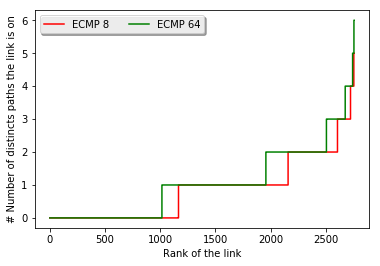

In [95]:
for i in lmap:
    lcount[lmap[i]] = 0

for i in range(N):
    run_bfs(i, permute_traffic[i], 64)


sorted_lcount = sorted(lcount.items(), key=operator.itemgetter(1))
# for i in sorted_lcount:
#     print i[1], reverse_lmap[i[0]]

plot_x64 = []
plot_y64 = []

for i in range(len(sorted_lcount)):
    plot_x64.append(i+1)
    plot_y64.append(sorted_lcount[i][1])

plt.plot(plot_x8, plot_y8, ls='solid', drawstyle='steps-post', label='ECMP 8', color='red')
plt.plot(plot_x64, plot_y64, ls='solid', drawstyle='steps-post', label='ECMP 64', color='green')
plt.legend(loc='upper left', ncol=2, mode="shrink", shadow=True, fancybox=True)
plt.xlabel('Rank of the link')
plt.ylabel('# Number of distincts paths the link is on')
plt.savefig('fig%d.png'%(N,), bbox_inches='tight')
plt.show()